<a href="https://colab.research.google.com/github/Gwan98/Project/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AutoEncoder

In [ ]:
# 필요한 라이브러리 로드

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns

from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [ ]:
# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [ ]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
# 데이터 가져오기

df = pd.read_csv("/content/drive/MyDrive/data_method1.csv")

In [ ]:
# 데이터 둘러보기

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,28747.000000,-2.424826,3.170580,-1.923592,0.786328,-1.236363,-1.139193,-0.881473,2.010733,-1.009046,...,0.290078,0.657969,0.308534,0.350326,-0.383362,-0.405547,0.234800,0.152174,0.890000,0
1,69652.000000,-7.434403,4.000947,-2.507947,3.537507,-4.823710,0.114263,-4.001537,4.723716,-1.616978,...,0.452607,-0.099938,-0.143582,0.472994,0.044446,0.041564,-3.180129,-1.489497,61.840000,0
2,139382.000000,-11.059166,-6.248048,-2.228612,-0.859962,-0.323507,0.049241,2.317499,-1.325281,2.664009,...,-2.898303,-0.496889,0.419184,0.444313,1.569429,-0.542982,-0.140952,0.983700,283.320000,0
3,77024.000000,-1.681994,0.928076,2.186931,-0.396015,-0.522530,-0.737281,0.631991,-0.575582,1.486306,...,0.080254,0.675759,-0.094717,0.948276,-0.188617,0.282785,-0.849293,-0.117922,4.950000,0
4,32102.000000,0.965570,-0.158240,0.231163,1.299259,-0.373301,-0.394270,0.120042,-0.017817,0.163276,...,0.153491,0.200973,-0.166351,0.061378,0.514986,-0.259438,0.004382,0.036175,120.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426463,37020.366289,-7.448033,-4.050255,-3.171826,4.553805,1.516735,-3.130865,-5.463226,0.462075,-0.000589,...,-0.447734,-0.420333,-4.346202,0.363006,-1.020204,0.507709,1.783623,-1.309939,11.394278,1
426464,71704.808570,-0.377964,0.553969,1.383718,2.127599,0.215711,1.249418,-0.928752,-1.625665,-0.245156,...,-0.365643,0.513727,-0.153797,-0.569395,-0.039091,0.081306,0.087574,-0.013130,20.207052,1
426465,94362.000000,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,...,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.000000,1
426466,154797.618422,-0.274707,4.146707,-6.048966,6.671597,0.978084,-1.693971,-1.849176,0.814960,-4.405062,...,0.428955,-0.400705,-0.203764,-0.984154,-0.079998,0.427339,0.638645,0.328034,1.146571,1


AutoEncoder 모델 만들기

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(170436, 29)

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

autoencoder = load_model('model.h5')

Epoch 1/100
5327/5327 [==============================] - 16s 3ms/step - loss: 0.8233 - accuracy: 0.5526 - val_loss: 13.7097 - val_accuracy: 0.3679
Epoch 2/100
5327/5327 [==============================] - 13s 2ms/step - loss: 0.7431 - accuracy: 0.6669 - val_loss: 13.8272 - val_accuracy: 0.4268
Epoch 3/100
5327/5327 [==============================] - 15s 3ms/step - loss: 0.7253 - accuracy: 0.6919 - val_loss: 14.1386 - val_accuracy: 0.4303
Epoch 4/100
5327/5327 [==============================] - 15s 3ms/step - loss: 0.7164 - accuracy: 0.7008 - val_loss: 13.5497 - val_accuracy: 0.4553
Epoch 5/100
5327/5327 [==============================] - 14s 3ms/step - loss: 0.7113 - accuracy: 0.7089 - val_loss: 13.6432 - val_accuracy: 0.5125
Epoch 6/100
5327/5327 [==============================] - 15s 3ms/step - loss: 0.7082 - accuracy: 0.7138 - val_loss: 13.5719 - val_accuracy: 0.4405
Epoch 7/100
5327/5327 [==============================] - 14s 3ms/step - loss: 0.7058 - accuracy: 0.7158 - val_loss: 13

In [ ]:
data = df.drop(['Class'], axis=1)
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
np.shape(data)
# predictions = autoencoder.predict(data)

# please = pd.DataFrame(predictions)
# please
# np.shape(predictions)

(426468, 30)

In [ ]:
please.to_csv('autoauto.csv')

ROC 곡선을 통한 평가

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,85300.000000,85300.000000
mean,0.018788,0.497069
std,0.027443,0.499994
min,0.000170,0.000000
25%,0.007660,0.000000
50%,0.009684,0.000000
75%,0.013154,1.000000
max,0.148141,1.000000


In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

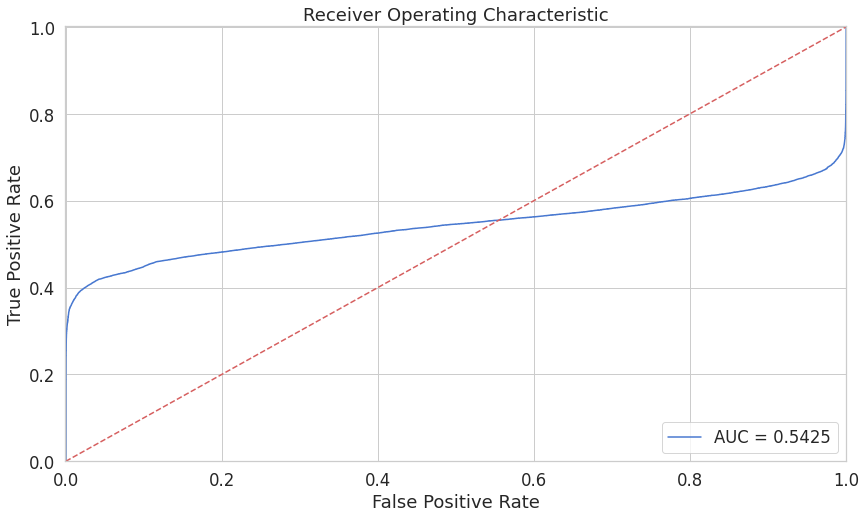

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

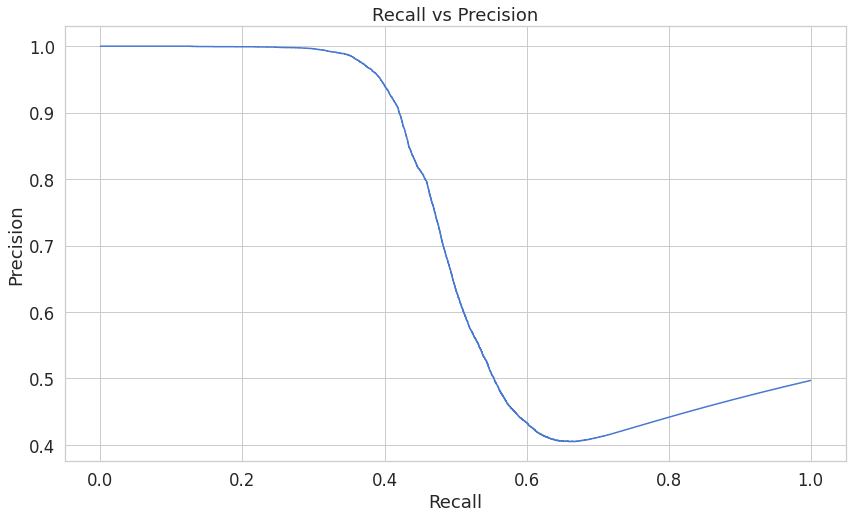

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

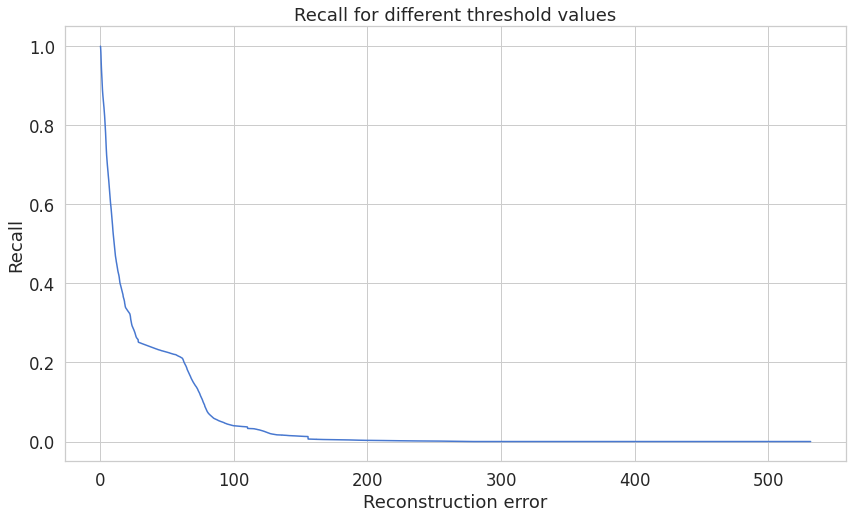

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()